# General information

Example colab for SigLIP models described in [the SigLIP paper](https://arxiv.org/abs/2303.15343).

**These models are not official Google products and were trained and released for research purposes.**

If you find our model(s) useful for your research, consider citing

```
@article{zhai2023sigmoid,
  title={Sigmoid loss for language image pre-training},
  author={Zhai, Xiaohua and Mustafa, Basil and Kolesnikov, Alexander and Beyer, Lucas},
  journal={International Conference on Computer Vision ({ICCV})},
  year={2023}
}
```

If you use our released models in your products, we will appreciate any direct feedback. We are reachable by xzhai@google.com, basilm@google.com, akolesnikov@google.com and lbeyer@google.com.


Only the models explicitly marked with `i18n` in the name are expected to perform reasonably well on non-english data.

In [ ]:
#@markdown # Environment setup
#@markdown **IMPORTANT NOTE**: Modern jax (>0.4) does not support the Colab TPU
#@markdown anymore, so don't select TPU runtime here. CPU and GPU work and are both fast enough.

# Install the right jax version for TPU/GPU/CPU
import os
if 'COLAB_TPU_ADDR' in os.environ:
  raise "TPU colab not supported."
elif 'NVIDIA_PRODUCT_NAME' in os.environ:
  !nvidia-smi
import jax
jax.devices()


# Get latest version of big_vision codebase.
!git clone --quiet --branch=main --depth=1 https://github.com/google-research/big_vision
!cd big_vision && git pull --rebase --quiet
!pip -q install -r big_vision/big_vision/requirements.txt
# Gives us ~2x faster gsutil cp to get the model checkpoints.
!pip3 -q install --no-cache-dir -U crcmod

%cd big_vision


import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import jax
import jax.numpy as jnp
import ml_collections

from google.colab.output import _publish as publish

#################

!pip install alibi-detect
!pip install easyfsl
import os
import torch
import tensorflow as tf
from tensorflow.keras.layers import InputLayer, Conv2D, Dense, Reshape, Conv2DTranspose, Flatten
from tqdm import tqdm
from easyfsl.datasets import EasySet
from torchvision import transforms
from alibi_detect.od import OutlierAE
from alibi_detect.saving import save_detector, load_detector

/bin/bash: line 1: nvidia-smi: command not found
fatal: destination path 'big_vision' already exists and is not an empty directory.
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
/content/big_vision


In [ ]:
#@title Mount Google Drive for data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Choose and load model, perform inference

In [ ]:
#@title Select model settings
# Pick your hero: (WHEN CHANGING THIS, RERUN IMAGE/TEXT EMBEDDING CELLS)
# Give this cell 1-3mins.

# Various settings for our SigLIP model
# VARIANT, RES = 'B/16', 224
# VARIANT, RES = 'B/16', 256
# VARIANT, RES = 'B/16', 384
# VARIANT, RES = 'B/16', 512
# VARIANT, RES = 'L/16', 256
VARIANT, RES = 'L/16', 384
# VARIANT, RES = 'So400m/14', 224
# VARIANT, RES = 'So400m/14', 384
# VARIANT, RES = 'B/16-i18n', 256

CKPT, TXTVARIANT, EMBDIM, SEQLEN, VOCAB = {
    ('B/16', 224): ('webli_en_b16_224_63724782.npz', 'B', 768, 64, 32_000),
    ('B/16', 256): ('webli_en_b16_256_60500360.npz', 'B', 768, 64, 32_000),
    ('B/16', 384): ('webli_en_b16_384_68578854.npz', 'B', 768, 64, 32_000),
    ('B/16', 512): ('webli_en_b16_512_68580893.npz', 'B', 768, 64, 32_000),
    ('L/16', 256): ('webli_en_l16_256_60552751.npz', 'L', 1024, 64, 32_000),
    ('L/16', 384): ('webli_en_l16_384_63634585.npz', 'L', 1024, 64, 32_000),
    ('So400m/14', 224): ('webli_en_so400m_224_57633886.npz', 'So400m', 1152, 16, 32_000),
    ('So400m/14', 384): ('webli_en_so400m_384_58765454.npz', 'So400m', 1152, 64, 32_000),
    ('B/16-i18n', 256): ('webli_i18n_b16_256_66117334.npz', 'B', 768, 64, 250_000),
}[VARIANT, RES]

# It is significantly faster to first copy the checkpoint (30s vs 8m30 for B and 1m vs ??? for L)
!test -f /tmp/{CKPT} || gsutil cp gs://big_vision/siglip/{CKPT} /tmp/

if VARIANT.endswith('-i18n'):
  VARIANT = VARIANT[:-len('-i18n')]

import big_vision.models.proj.image_text.two_towers as model_mod

model_cfg = ml_collections.ConfigDict()
model_cfg.image_model = 'vit'  # TODO(lbeyer): remove later, default
model_cfg.text_model = 'proj.image_text.text_transformer'  # TODO(lbeyer): remove later, default
model_cfg.image = dict(variant=VARIANT, pool_type='map')
model_cfg.text = dict(variant=TXTVARIANT, vocab_size=VOCAB)
model_cfg.out_dim = (None, EMBDIM)  # (image_out_dim, text_out_dim)
model_cfg.bias_init = -10.0
model_cfg.temperature_init = 10.0

model = model_mod.Model(**model_cfg)

# Using `init_params` is slower but will lead to `load` below performing sanity-checks.
# init_params = jax.jit(model.init, backend="cpu")(jax.random.PRNGKey(42), jnp.zeros([1, RES, RES, 3], jnp.float32), jnp.zeros([1, SEQLEN], jnp.int32))['params']
init_params = None  # Faster but bypasses loading sanity-checks.

params = model_mod.load(init_params, f'/tmp/{CKPT}', model_cfg)

######################

# Set-up Outlier detection
PROJECT_BASE_PATH = "/content/drive/MyDrive/CS 229 Project"  # Change to match your mounted drive layout
saved_detector_name = "outlier_save"
saved_detector_path = os.path.join(PROJECT_BASE_PATH, saved_detector_name)

outlier_detector = load_detector(saved_detector_path)

Copying gs://big_vision/siglip/webli_en_l16_384_63634585.npz...
/ [1 files][  2.3 GiB/  2.3 GiB]   80.0 MiB/s                                   
Operation completed over 1 objects/2.3 GiB.                                      


In [ ]:
#@title Tokenize and embed texts

import big_vision.pp.builder as pp_builder
import big_vision.pp.ops_general
import big_vision.pp.ops_image
import big_vision.pp.ops_text
import PIL
import os
import random

texts = countries_and_flags = [
    "Afghanistan flag",
    "Albania flag",
    "Algeria flag",
    "Andorra flag",
    "Angola flag",
    "Antigua and Barbuda flag",
    "Argentina flag",
    "Armenia flag",
    "Australia flag",
    "Austria flag",
    "Azerbaijan flag",
    "Bahamas flag",
    "Bahrain flag",
    "Bangladesh flag",
    "Barbados flag",
    "Belarus flag",
    "Belgium flag",
    "Belize flag",
    "Benin flag",
    "Bhutan flag",
    "Bolivia flag",
    "Bosnia and Herzegovina flag",
    "Botswana flag",
    "Brazil flag",
    "Brunei flag",
    "Bulgaria flag",
    "Burkina Faso flag",
    "Burundi flag",
    "Cambodia flag",
    "Cameroon flag",
    "Canada flag",
    "Cape Verde flag",
    "Central African Republic flag",
    "Chad flag",
    "Chile flag",
    "China flag",
    "Colombia flag",
    "Comoros flag",
    "Costa Rica flag",
    "Croatia flag",
    "Cuba flag",
    "Cyprus flag",
    "Czechia flag",
    "Democratic Republic of the Congo flag",
    "Denmark flag",
    "Djibouti flag",
    "Dominica flag",
    "Dominican Republic flag",
    "East Timor flag",
    "Ecuador flag",
    "Egypt flag",
    "El Salvador flag",
    "Equatorial Guinea flag",
    "Eritrea flag",
    "Estonia flag",
    "Eswatini flag",
    "Ethiopia flag",
    "Fiji flag",
    "Finland flag",
    "France flag",
    "Gabon flag",
    "Gambia flag",
    "Georgia flag",
    "Germany flag",
    "Ghana flag",
    "Greece flag",
    "Grenada flag",
    "Guatemala flag",
    "Guinea flag",
    "Guinea Bissau flag",
    "Guyana flag",
    "Haiti flag",
    "Honduras flag",
    "Hungary flag",
    "Iceland flag",
    "India flag",
    "Indonesia flag",
    "Iran flag",
    "Iraq flag",
    "Ireland flag",
    "Israel flag",
    "Italy flag",
    "Jamaica flag",
    "Japan flag",
    "Jordan flag",
    "Kazakhstan flag",
    "Kenya flag",
    "Kiribati flag",
    "Korea North flag",
    "Korea South flag",
    "Kosovo flag",
    "Kuwait flag",
    "Kyrgyzstan flag",
    "Laos flag",
    "Latvia flag",
    "Lebanon flag",
    "Lesotho flag",
    "Liberia flag",
    "Libya flag",
    "Liechtenstein flag",
    "Lithuania flag",
    "Luxembourg flag",
    "Madagascar flag",
    "Malawi flag",
    "Malaysia flag",
    "Maldives flag",
    "Mali flag",
    "Malta flag",
    "Marshall Islands flag",
    "Mauritania flag",
    "Mauritius flag",
    "Mexico flag",
    "Micronesia flag",
    "Moldova flag",
    "Monaco flag",
    "Mongolia flag",
    "Montenegro flag",
    "Morocco flag",
    "Mozambique flag",
    "Myanmar flag",
    "Namibia flag",
    "Nauru flag",
    "Nepal flag",
    "Netherlands flag",
    "New Zealand flag",
    "Nicaragua flag",
    "Niger flag",
    "Nigeria flag",
    "North Macedonia flag",
    "Norway flag",
    "Oman flag",
    "Pakistan flag",
    "Palau flag",
    "Panama flag",
    "Papua New Guinea flag",
    "Paraguay flag",
    "Peru flag",
    "Philippines flag",
    "Poland flag",
    "Portugal flag",
    "Qatar flag",
    "Republic of the Congo flag",
    "Romania flag",
    "Russia flag",
    "Rwanda flag",
    "Saint Kitts and Nevis flag",
    "Saint Lucia flag",
    "Saint Vincent and the Grenadines flag",
    "Samoa flag",
    "San Marino flag",
    "Sao Tome and Principe flag",
    "Saudi Arabia flag",
    "Senegal flag",
    "Serbia flag",
    "Seychelles flag",
    "Sierra Leone flag",
    "Singapore flag",
    "Slovakia flag",
    "Slovenia flag",
    "Solomon Islands flag",
    "Somalia flag",
    "South Africa flag",
    "South Sudan flag",
    "Spain flag",
    "Sri Lanka flag",
    "State of Palestine flag",
    "Sudan flag",
    "Suriname flag",
    "Sweden flag",
    "Switzerland flag",
    "Syria flag",
    "Taiwan flag",
    "Tajikistan flag",
    "Tanzania flag",
    "Thailand flag",
    "Togo flag",
    "Tonga flag",
    "Trinidad and Tobago flag",
    "Tunisia flag",
    "Turkey flag",
    "Turkmenistan flag",
    "Tuvalu flag",
    "Uganda flag",
    "Ukraine flag",
    "United Arab Emirates flag",
    "United Kingdom flag",
    "United States of America flag",
    "Uruguay flag",
    "Uzbekistan flag",
    "Vanuatu flag",
    "Vatican City flag",
    "Venezuela flag",
    "Vietnam flag",
    "Yemen flag",
    "Zambia flag",
    "Zimbabwe flag",
    "Solid square of color",
    "Creative flag"
]

TOKENIZERS = {
    32_000: 'c4_en',
    250_000: 'mc4',
}
pp_txt = pp_builder.get_preprocess_fn(f'tokenize(max_len={SEQLEN}, model="{TOKENIZERS[VOCAB]}", eos="sticky", pad_value=1, inkey="text")')
txts = np.array([pp_txt({'text': text})['labels'] for text in texts])
_, ztxt, out = model.apply({'params': params}, None, txts)

print(txts.shape, ztxt.shape)

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


(198, 64) (198, 1024)


In [ ]:
#@title Run all image test
import json

with open("/content/drive/MyDrive/CS 229 Project/final_data.json", 'r') as in_fp:
  final_data = json.load(in_fp)

base_path = "/content/drive/MyDrive/CS 229 Project/data/"

image_paths = []

# Get all of our images
for folder_idx in range(10):
  files = os.listdir(base_path + f"{folder_idx}_test/")
  for file_path in files:
    image_paths.append((base_path + f"{folder_idx}_test/", file_path))

num_total = 0
num_country = 0
num_edge = 0
num_country_correct = 0
num_edge_correct = 0

predictions = {}

# Iteratively go through instead of doing all the images at once
for image_duo in image_paths:
  image_path = image_duo[1]
  image = PIL.Image.open(image_duo[0] + image_duo[1])

  pp_img = pp_builder.get_preprocess_fn(f'resize({RES})|value_range(-1, 1)')
  img = np.array([pp_img({'image': np.array(image)})['image']])
  zimg, _, out = model.apply({'params': params}, img, None)

  probs = jax.nn.sigmoid(zimg @ ztxt.T * out['t'] + out['b'])

  predicted_labels = []
  corresponding_probs = []
  for i in range(len(probs)):
    prob = probs[i]
    indices = np.where(prob > 0.6)[0]
    predicted_labels.append([])
    corresponding_probs.append([])
    if indices.any():
      for index in indices:
        predicted_labels[i].append(texts[index])
        corresponding_probs[i].append(float(probs[i, index]))
    else:
      predicted_labels[i].append("edge")

  prediction = predicted_labels[0][0]

  if prediction == 'edge':
    results = outlier_detector.predict([img],
                                      outlier_type="instance",
                                      return_feature_score=True,
                                      return_instance_score=True)
    selected_threshold = 0.05
    outlier = results["data"]["instance_score"][0] >= selected_threshold

  # Check vs truth
  truth = final_data[image_path]
  if prediction == "edge":
    prediction = "creative" if outlier else "bug"

  predictions[image_path] = prediction

  if truth["country"] not in ["edge", "blank"]:  # truth not an edge case
    if prediction != "bug":  # pred not misclassified as false
        num_country_correct += 1

    num_country += 1
  elif "complexity" in truth:
    if prediction != "bug" and truth["complexity"] > 1:
      num_edge_correct += 1
    elif prediction == "bug" and truth["complexity"] <= 1:
      num_edge_correct += 1
    num_edge += 1

In [ ]:
num_total = num_country + num_edge
num_correct = num_country_correct + num_edge_correct
print(f"{'Country Flags':<20}", num_country_correct, '/', num_country, '=', num_country_correct / num_country)
print(f"{'Edge Case Flags':<20}", num_edge_correct, '/', num_edge, '=', num_edge_correct / num_edge)
print(f"{'Total Test Accuracy':<20}", num_correct, '/', num_total, '=', num_correct / num_total)

Country Flags        158 / 159 = 0.9937106918238994
Edge Case Flags      223 / 239 = 0.9330543933054394
Total Test Accuracy  381 / 398 = 0.957286432160804


In [ ]:
bug_correct = 0
bug_total = 0

creative_correct = 0
creative_total = 0

creative_flags_correct = []
creative_flags_incorrect = []
buggy_flags_correct = []
buggy_flags_incorrect = []

for img_path in predictions:
  truth = final_data[img_path]
  prediction = predictions[img_path]

  if truth["country"] in ["edge", "blank"] and "complexity" in truth:
    if truth["complexity"] > 1:
      if prediction != "bug":
        creative_correct += 1
        creative_flags_correct.append(img_path)
      else:
        creative_flags_incorrect.append(img_path)

      creative_total += 1
    else:
      if prediction == "bug":
        bug_correct += 1
        buggy_flags_correct.append(img_path)
      else:
        buggy_flags_incorrect.append(img_path)

      bug_total += 1

print(f"{'Creative Flags':<20}", creative_correct, '/', creative_total, '=', creative_correct / creative_total)
print(f"{'Buggy Flags':<20}", bug_correct, '/', bug_total, '=', bug_correct / bug_total)
print(f"{'Edge Case Flags':<20}", bug_correct + creative_correct, '/', bug_total + creative_total, '=', (bug_correct + creative_correct) / (bug_total + creative_total))

Creative Flags       66 / 67 = 0.9850746268656716
Buggy Flags          157 / 172 = 0.9127906976744186
Edge Case Flags      223 / 239 = 0.9330543933054394


# Demo

In [ ]:
#@title Load and embed (randomly selected) images

# Example using online resource instead of local data
# !wget -q https://cdn.openai.com/multimodal-neurons/assets/apple/apple-ipod.jpg

base_path = "/content/drive/MyDrive/CS 229 Project/data/"

data_folders = []
image_paths = []

NUM_IMAGES = 6

# Roundabout way to get images since the directory structure is poor
for i in range(NUM_IMAGES):
  data_folders.append(random.randint(0, 9))

for folder_idx in data_folders:
  files = os.listdir(base_path + f"{folder_idx}_test/")
  image_paths.append(base_path + f"{folder_idx}_test/" + random.sample(files, k=1)[0])

images = [PIL.Image.open(fname) for fname in image_paths]

pp_img = pp_builder.get_preprocess_fn(f'resize({RES})|value_range(-1, 1)')
imgs = np.array([pp_img({'image': np.array(image)})['image'] for image in images])
zimg, _, out = model.apply({'params': params}, imgs, None)

print(data_folders)
print(imgs.shape, zimg.shape)

[2, 4, 5, 6, 9, 3]
(6, 384, 384, 3) (6, 1024)


In [ ]:
#@title Predict flag classification
# This is how to get all probabilities:
print(f"Learned temperature {out['t'].item():.1f}, learned bias: {out['b'].item():.1f}\n")
probs = jax.nn.sigmoid(zimg @ ztxt.T * out['t'] + out['b'])

predicted_labels = []
corresponding_probs = []
for i in range(len(probs)):
  prob = probs[i]
  indices = np.where(prob > 0.6)[0]
  predicted_labels.append([])
  corresponding_probs.append([])
  if indices.any():
    for index in indices:
      predicted_labels[i].append(texts[index])
      corresponding_probs[i].append(float(probs[i, index]))
  else:
    predicted_labels[i].append("edge")

# print(f"{probs[0][0]:.1%} that image 0 is '{texts[0]}'")
# print(f"{probs[0][1]:.1%} that image 0 is '{texts[1]}'")

# print(corresponding_probs)
# print(len(corresponding_probs))

Learned temperature 118.2, learned bias: -12.7



In [ ]:
#@title Use Outlier Detector
# Set the base path to specify where we are working

edge_cases = []
edge_case_orig_indexes = []
for i in range(len(predicted_labels)):
  labels = predicted_labels[i]
  if "edge" in labels:
    edge_cases.append(imgs[i])
    edge_case_orig_indexes.append(i)

edge_cases = np.array(edge_cases)

if edge_cases.size > 0:
  results = outlier_detector.predict(edge_cases,
                                    outlier_type="instance",
                                    return_feature_score=True,
                                    return_instance_score=True)

  print(results["data"]["instance_score"])

[0.79663384 0.82584953 0.6353227 ]


Orig Indexes: [1, 4, 5]
Outliers: [1, 4, 5]
Inliers: []


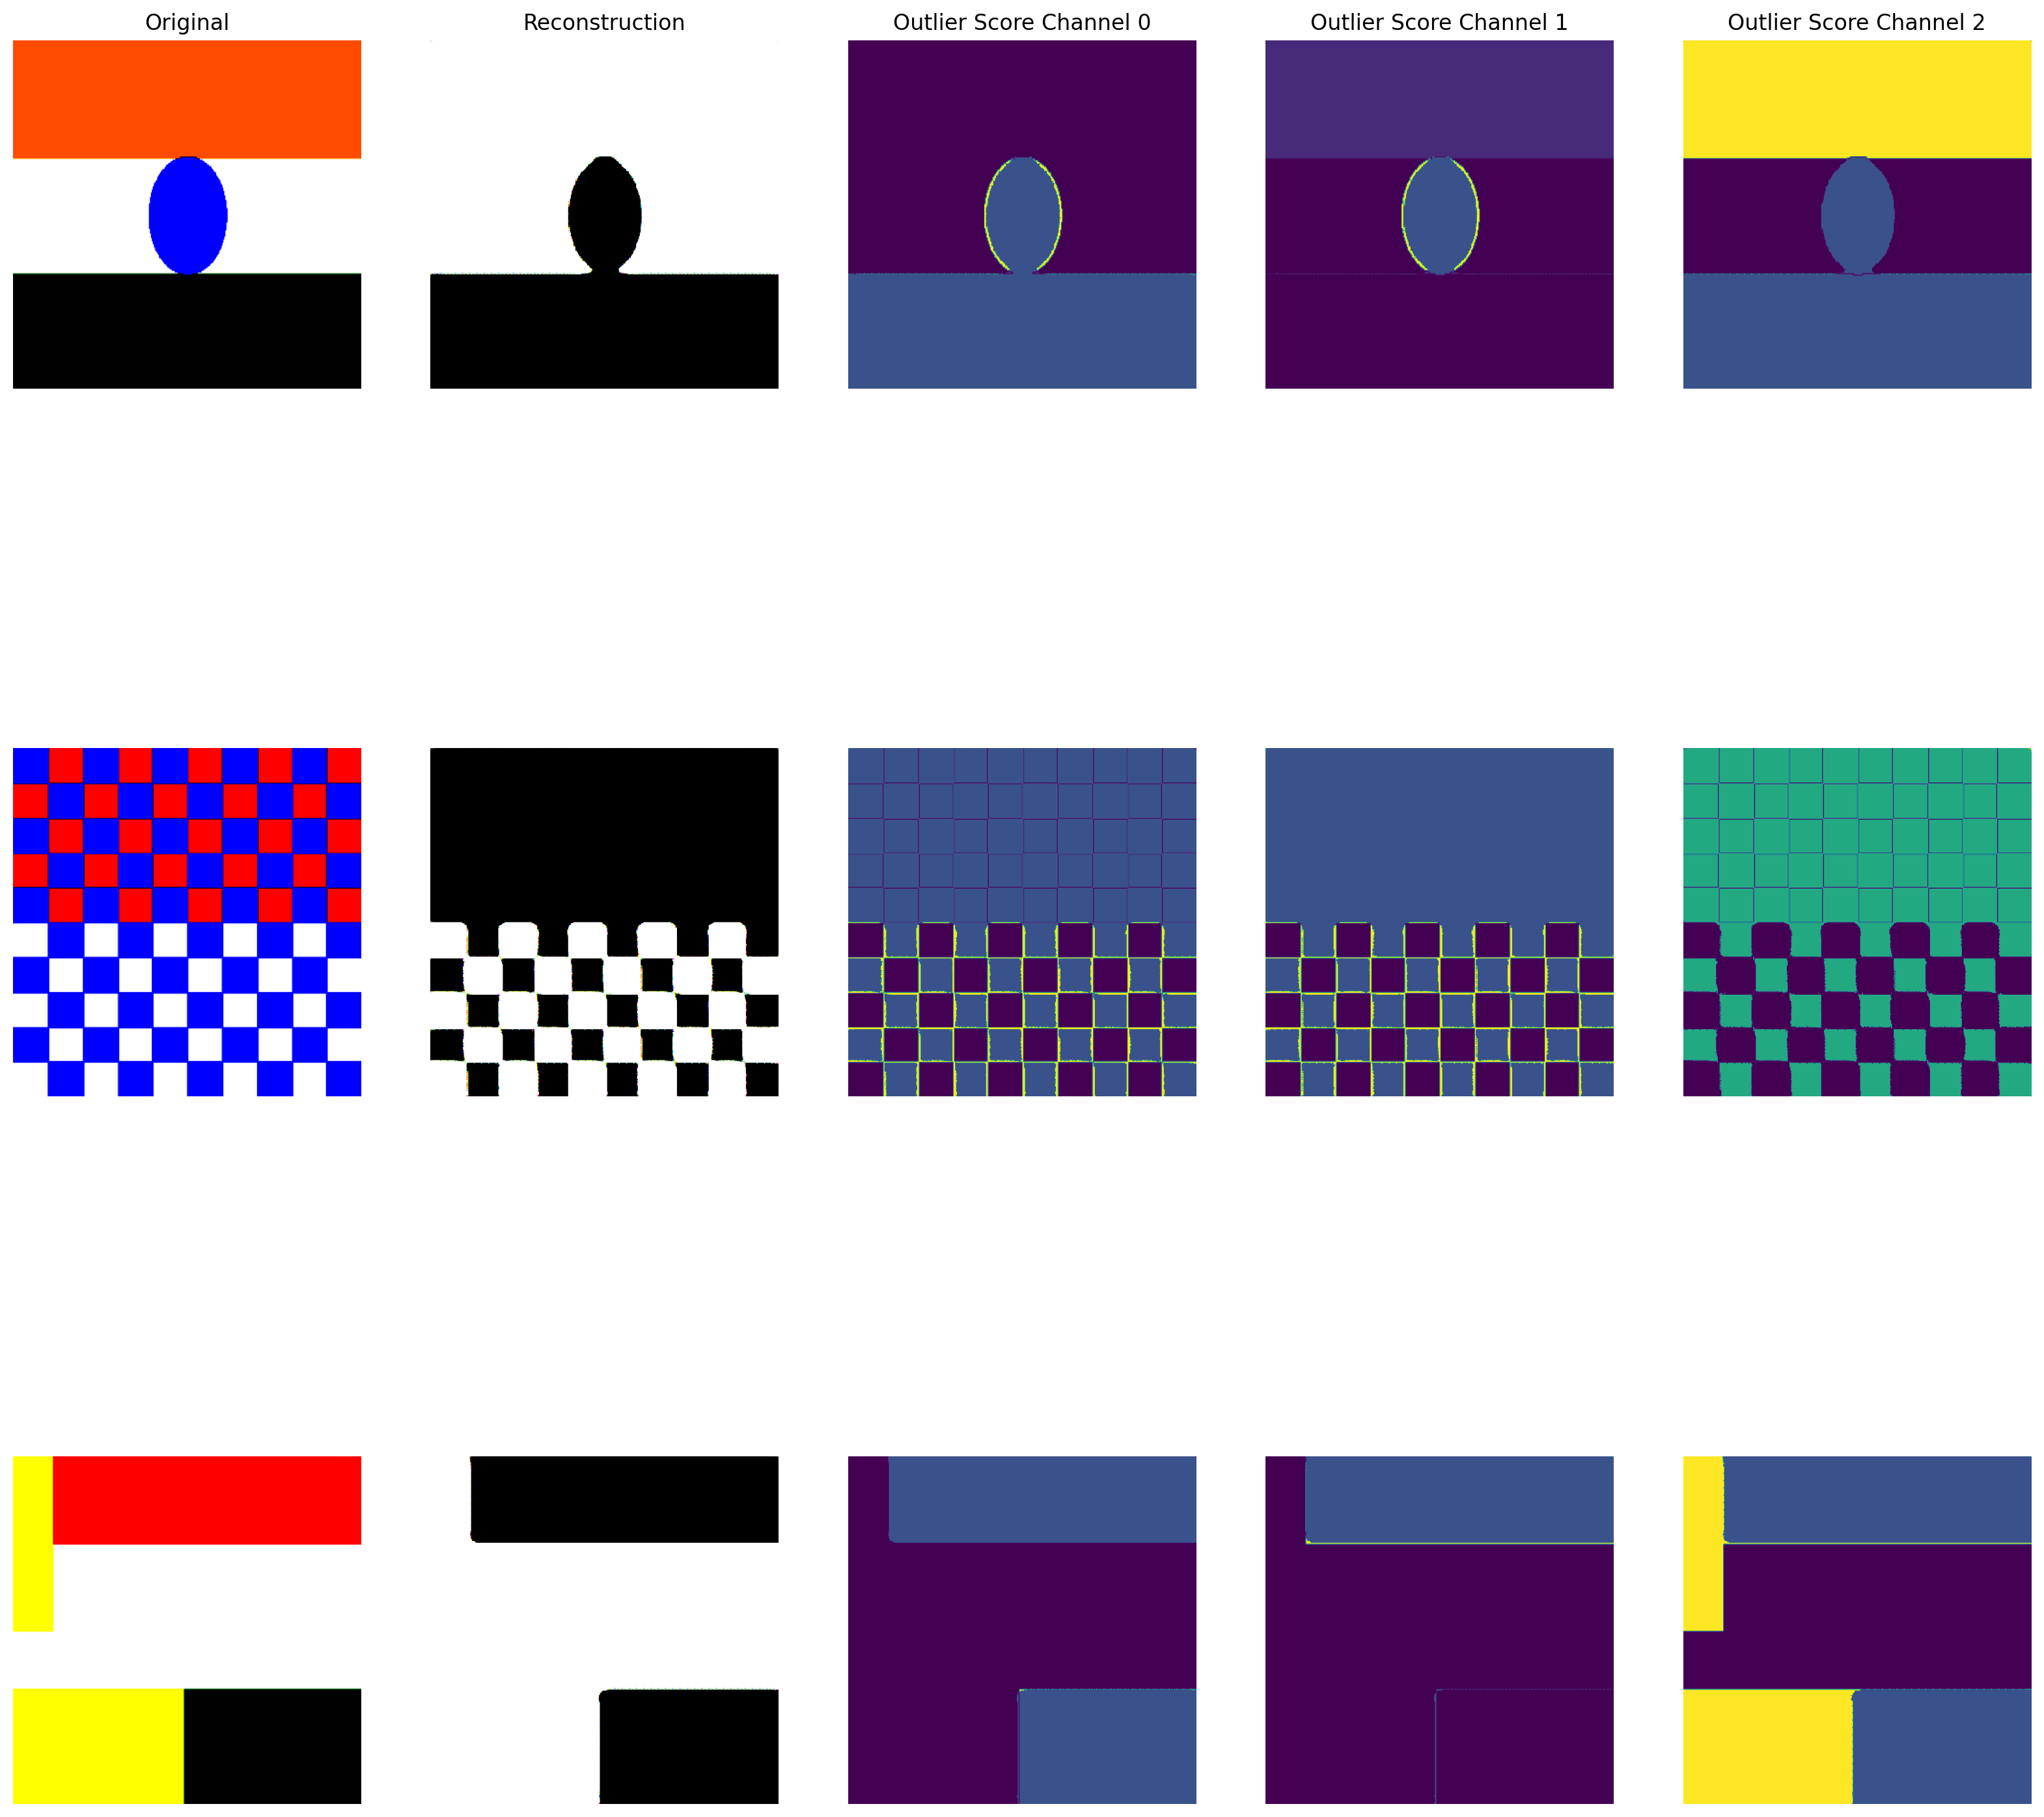

In [ ]:
#@title Demo of Outlier Model's Reconstruction
if edge_cases.size > 0:
  selected_threshold = 0.05
  outlier_indices = np.where(results['data']["instance_score"] > selected_threshold)[0]
  inlier_indices = np.where(results['data']["instance_score"] <= selected_threshold)[0]

  recon = outlier_detector.ae(tf.convert_to_tensor(edge_cases)).numpy()

  outliers = [edge_case_orig_indexes[i] for i in outlier_indices]
  inliers = [edge_case_orig_indexes[i] for i in inlier_indices]
  print("Orig Indexes:", edge_case_orig_indexes)
  print("Outliers:", [edge_case_orig_indexes[i] for i in outlier_indices])
  print("Inliers:", [edge_case_orig_indexes[i] for i in inlier_indices])

  from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_image

  if len(outlier_indices) > 0:
    plot_feature_outlier_image(results,
                              edge_cases,
                              X_recon=recon,
                              instance_ids=outlier_indices,  # pass a list with indices of instances to display
                              n_channels=3,
                              outliers_only=False)

In [ ]:
# @title Pretty demo (code)
from IPython.display import Javascript

DEMO_IMG_SIZE = 96

import base64
import io

def bv2rgb(bv_img):
  return (bv_img * 127.5 + 127.5).astype(np.uint8)

def html_img(*, enc_img=None, pixels=None, id=None, size=100, max_size=None, max_height=None, style=""):
  if enc_img is None and pixels is not None:
    with io.BytesIO() as buf:
      PIL.Image.fromarray(np.asarray(pixels)).save(buf, format="JPEG")
      enc_img = buf.getvalue()

  img_data = base64.b64encode(np.ascontiguousarray(enc_img)).decode('ascii')

  id_spec = f'id={id}' if id else ''
  if size is not None:
    style_spec = f'style="{style}; width: {size}px; height: {size}px"'
  elif max_size is not None:
    style_spec = f'style="{style}; width: auto; height: auto; max-width: {max_size}px; max-height: {max_size}px;"'
  elif max_height is not None:
    style_spec = f'style="{style}; object-fit: cover; width: auto; height: {max_height}px;"'
  else: style_spec = ''

  return f'<img {id_spec} {style_spec} src="data:image/png;base64,{img_data}"/>'


def make_table(zimg, ztxt, out):
  # The default learnable bias is a little conservative. Play around with it!
  t, b = out['t'].item(), out['b'].item()
  tempered_logits = zimg @ ztxt.T * t
  probs = 1 / (1 + np.exp(-tempered_logits - b))
  publish.javascript(f"var logits = {tempered_logits.tolist()};")

  def color(p):
    return mpl.colors.rgb2hex(mpl.cm.Greens(p / 2)) if p >= 0.01 else "transparent"

  publish.javascript(f"var cmap = {[color(x) for x in np.linspace(0, 1, 50)]};")
  def cell(x, iimg, itxt):
    return f"<td id=td_{iimg}_{itxt} style=background-color:{color(x)} class=pct><pre id=p_{iimg}_{itxt}>{x * 100:>4.0f}%</pre>"

  html = f'''
  <p>
  <label for=b>Bias value:</label>
  <input id=b type=range min=-15 max=0 step=0.1 name=b value={b} style=vertical-align:middle>
  <output id=value></output>
  </p>
  '''

  html += "<table>\n"
  html += "<tr>"
  html += "".join([f"<td style='width:{DEMO_IMG_SIZE}px;line-height:0'>" + html_img(pixels=bv2rgb(img), size=DEMO_IMG_SIZE) for img in imgs])
  html += "<td>"
  # for itxt, txt in enumerate(texts):
  #   html += f"<tr>" + "".join([cell(probs[iimg, itxt], iimg, itxt) for iimg in range(len(imgs))]) + f"<td class=txt>{txt}"

  publish.css(r"""
  table {
    border-collapse: collapse;
  }

  tr {
    border: 1px transparent;
  }

  tr:nth-child(odd) {
    background-color: #F5F5F5;
  }

  tr:hover {
    background-color: lightyellow;
    border: 1px solid black;
  }

  td.pct {
    text-align: center;
  }
  """)
  publish.html(html)

  # JS code to compute and write all probs from the logits.
  display(Javascript('''
  function update(b) {
    for(var iimg = 0; iimg < logits.length; iimg++) {
      for(var itxt = 0; itxt < logits[iimg].length; itxt++) {
        const el = document.getElementById(`p_${iimg}_${itxt}`);
        const p = Math.round(100 / (1 + Math.exp(-logits[iimg][itxt] - b)));
        const pad = p < 10.0 ? '  ' : p < 100.0 ? ' ' : ''
        el.innerHTML = pad + (p).toFixed(0) + '%';

        const td = document.getElementById(`td_${iimg}_${itxt}`);
        const c = cmap[Math.round(p / 100 * (cmap.length - 1))];
        td.style.backgroundColor = c;
      }
    }
  }
  '''))

  # JS code to connect the bias value slider
  display(Javascript('''
  const value = document.querySelector("#value");
  const input = document.querySelector("#b");
  value.textContent = input.value;
  input.addEventListener("input", (event) => {
    value.textContent = event.target.value;
    update(event.target.value);
  });
  '''))

  # Make the cell output as large as the table to avoid annoying scrollbars.
  display(Javascript(f'update({b})'))
  display(Javascript('google.colab.output.resizeIframeToContent()'))

In [ ]:
#@title Label Outliers

outliers = [edge_case_orig_indexes[i] for i in outlier_indices]
for outlier_idx in outliers:
  predicted_labels[outlier_idx] = ["creative"]

for inlier_idx in inliers:
  predicted_labels[inlier_idx] = ["bug"]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


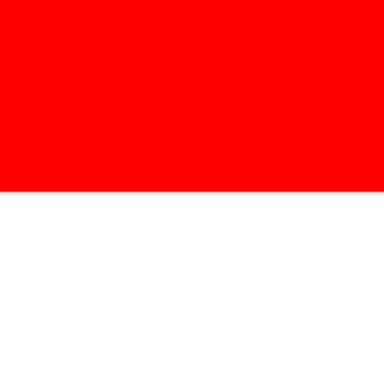
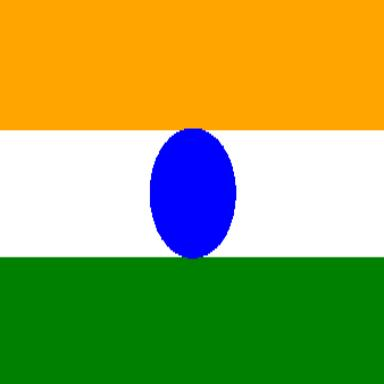
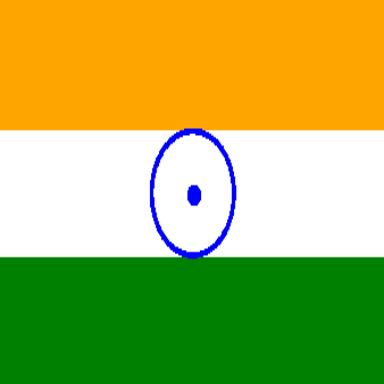
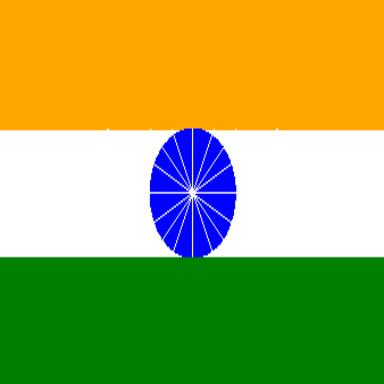
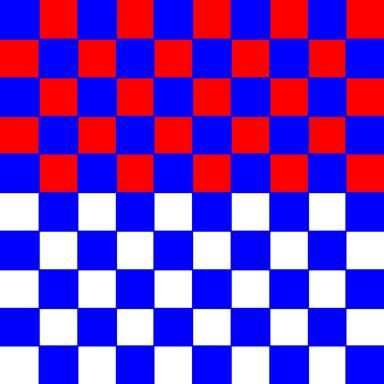
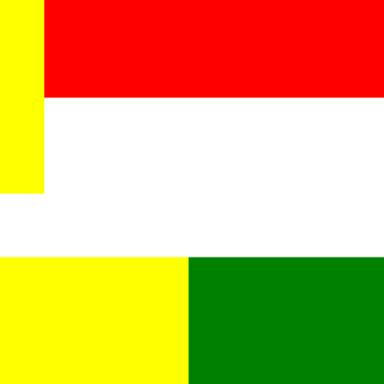

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[['Indonesia flag', 'Monaco flag'], ['creative'], ['India flag'], ['India flag'], ['creative'], ['creative']]


In [ ]:
#@title Pretty Demo (visuals)
make_table(zimg, ztxt, out)
print(predicted_labels)